In [36]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Identify Nodes

In [37]:
def identify_nodes(circuit):
    # Extract nodes from the circuit description
    nodes = []
    for element in circuit:
        if element["type"] != "ground":
            nodes.extend(element["nodes"])
    nodes = list(set(nodes))  # Remove duplicate nodes
    return nodes



## Create Digraph Model

In [38]:
def create_digraph_model(circuit):
    digraph = {
        "nodes": [],
        "edges": [],
        "num_nodes": 0,
        "num_resistors": 0,
        "num_voltage_sources": 0,
        "num_current_sources": 0
    }

    for element in circuit:
        if element["type"] == "resistor":
            digraph["edges"].append(
                {"type": "resistor", "nodes": element["nodes"], "value": element["value"]})
            digraph["num_resistors"] += 1
        elif element["type"] == "voltage_source":
            digraph["edges"].append(
                {"type": "voltage_source", "nodes": element["nodes"], "value": element["value"]})
            digraph["num_voltage_sources"] += 1
        elif element["type"] == "current_source":
            digraph["edges"].append(
                {"type": "current_source", "nodes": element["nodes"], "value": element["value"]})
            digraph["num_current_sources"] += 1

    digraph["nodes"] = list(
        set([node for edge in digraph["edges"] for node in edge["nodes"]]))
    digraph["num_nodes"] = len(digraph["nodes"])

    return digraph

## Create Incidence Matrix

In [39]:
def create_incidence_matrix(digraph):
    num_nodes = digraph["num_nodes"]
    num_edges = len(digraph["edges"])
    A_g = np.zeros((num_edges, num_nodes))

    for j, edge in enumerate(digraph["edges"]):
        nodes = edge["nodes"]
        if len(nodes) == 2:
            A_g[j, digraph["nodes"].index(nodes[0])] = 1
            A_g[j, digraph["nodes"].index(nodes[1])] = -1

    return A_g

## Create Circuit Vectors

In [40]:
def create_circuit_vectors(digraph):
    num_nodes = digraph["num_nodes"]
    num_edges = len(digraph["edges"])
    u_g = np.zeros(num_nodes)
    v = np.zeros(num_edges)
    i = np.zeros(num_edges)

    for j, edge in enumerate(digraph["edges"]):
        if edge["type"] == "voltage_source":
            v[j] = edge["value"]
        elif edge["type"] == "current_source":
            i[j] = edge["value"]

    return u_g, v, i

## State Circuit Equations

In [41]:
def state_circuit_equations(A_g, u_g, v, i):
    equations = {
        "KVL": A_g @ u_g - v,
        "KCL": A_g.T @ i
    }
    return equations

## Determine Nodes

In [42]:
def determine_nodes(nodes, digraph):
    ordinary_nodes = []
    generalized_nodes = []

    # Find nodes connected by voltage sources
    voltage_source_nodes = set()
    for edge in digraph["edges"]:
        if edge["type"] == "voltage_source":
            voltage_source_nodes.update(edge["nodes"])

    # Determine ordinary and generalized nodes
    for node in nodes:
        if node in voltage_source_nodes:
            # Check if the node is part of a generalized node
            connected_nodes = set()
            stack = [node]
            while stack:
                current_node = stack.pop()
                connected_nodes.add(current_node)
                for edge in digraph["edges"]:
                    if edge["type"] == "voltage_source" and current_node in edge["nodes"]:
                        other_node = edge["nodes"][0] if current_node == edge["nodes"][1] else edge["nodes"][1]
                        if other_node not in connected_nodes:
                            stack.append(other_node)
            generalized_nodes.append(list(connected_nodes))
        else:
            ordinary_nodes.append(node)

    # Remove duplicate generalized nodes
    generalized_nodes = [list(x) for x in set(
        tuple(sorted(x)) for x in generalized_nodes)]

    return ordinary_nodes, generalized_nodes

## Ground Circuit

In [43]:
def ground_circuit(A_g, u_g, ground_node_index):
    num_nodes = len(u_g)
    D_0 = np.eye(num_nodes)[:, np.arange(num_nodes) != ground_node_index]
    A_0 = A_g @ D_0
    u_0 = D_0.T @ u_g
    return A_0, u_0

## State Grounded Equations

In [44]:
def state_grounded_equations(A_0, u_0, v, i, digraph):
    num_resistors = digraph["num_resistors"]
    num_voltage_sources = digraph["num_voltage_sources"]

    A_r_0 = A_0[:num_resistors]
    A_v_0 = A_0[num_resistors:num_resistors + num_voltage_sources]
    A_i_0 = A_0[num_resistors + num_voltage_sources:]

    v_r = v[:num_resistors]
    v_v = v[num_resistors:num_resistors + num_voltage_sources]
    v_i = v[num_resistors + num_voltage_sources:]

    i_r = i[:num_resistors]
    i_v = i[num_resistors:num_resistors + num_voltage_sources]
    i_i = i[num_resistors + num_voltage_sources:]

    grounded_equations = {
        "KVL_r": A_r_0 @ u_0 - v_r,
        "KVL_v": A_v_0 @ u_0 - v_v,
        "KVL_i": A_i_0 @ u_0 - v_i,
        "KCL": A_r_0.T @ i_r + A_v_0.T @ i_v + A_i_0.T @ i_i
    }

    return grounded_equations

## Identify Node Types

In [45]:
def identify_node_types(nodes, ground_node, generalized_nodes):
    essential_nodes = []
    nonessential_nodes = []
    supernodes = []

    for node in nodes:
        if node == ground_node:
            continue

        if node in [n for gn in generalized_nodes for n in gn]:
            if ground_node in [n for gn in generalized_nodes for n in gn]:
                nonessential_nodes.append(node)
            else:
                supernodes.append(node)
        else:
            essential_nodes.append(node)

    return essential_nodes, nonessential_nodes, supernodes

## Eliminate Node Dependencies

In [46]:
def eliminate_node_dependencies(A_g, u_g, v_v, generalized_nodes):
    num_nodes = len(u_g)
    num_voltage_sources = len(v_v)

    # Create a mapping of nodes to their corresponding generalized node
    node_to_generalized = {}
    for gn in generalized_nodes:
        for node in gn:
            node_to_generalized[node] = gn

    # Assign independent and dependent node voltage potentials
    independent_nodes = []
    dependent_nodes = []
    for gn in generalized_nodes:
        independent_node = gn[0]
        independent_nodes.append(independent_node)
        dependent_nodes.extend(gn[1:])

    # Create the D_v_g matrix
    num_independent_nodes = len(independent_nodes)
    num_remaining_nodes = num_nodes - num_independent_nodes - num_voltage_sources
    D_v_g = np.zeros((num_nodes, num_independent_nodes + num_remaining_nodes))
    for i, node in enumerate(independent_nodes + [n for n in range(num_nodes) if n not in node_to_generalized]):
        if i < D_v_g.shape[1]:
            D_v_g[node, i] = 1

    # Create the u vector
    u = [u_g[node] for node in independent_nodes]

    # Create the p_g vector
    p_g = np.zeros(num_nodes)
    for node, gn in node_to_generalized.items():
        if node != gn[0]:
            gn_index = generalized_nodes.index(gn)
            if gn_index < len(v_v) and node < p_g.shape[0]:
                p_g[node] = u_g[gn[0]] - v_v[gn_index]

    return D_v_g, u, p_g

## State Deflated Equation

In [47]:
def state_deflated_equations(A_0, D_v_g, u, p_g, i_i, digraph):
    num_nodes = A_0.shape[1]
    num_voltage_sources = digraph["num_voltage_sources"]
    num_resistors = digraph["num_resistors"]

    # Create the grounded voltage source deflation matrix D
    D = D_v_g[:num_nodes, :num_nodes - num_voltage_sources]

    # Create the fully deflated incidence matrix A
    A = A_0 @ D
    A_r = A[:num_resistors]
    A_v = A[num_resistors:num_resistors + num_voltage_sources]
    A_i = A[num_resistors + num_voltage_sources:]

    # Create the grounded particular solution vector p_0
    p_0 = p_g[:num_nodes - num_voltage_sources]

    # Create the conductance matrix G
    G = np.diag([1 / edge["value"]
                for edge in digraph["edges"] if edge["type"] == "resistor"])

    # Create the K matrix and f vector
    K = A_r.T @ G @ A_r
    f = A_i.T @ i_i - A_r.T @ G @ (A_r @ p_0)

    return K, f

In [48]:
def solve_lana_equation(K, f):
    u = np.linalg.pinv(K) @ f
    return u

## Calculate Circuit Variables

In [49]:
def calculate_circuit_variables(u, p_0, D, digraph):
    # Calculate node voltage potentials
    u_0 = p_0.reshape(-1, 1)[:D.shape[0]] + D @ u.reshape(-1, 1)
    node_potentials = np.zeros(len(digraph["nodes"]))
    node_potentials[:u_0.shape[0]] = u_0.flatten()

    # Calculate voltage drops across each element
    v = {}
    for edge in digraph["edges"]:
        if edge["type"] == "resistor":
            node_from, node_to = edge["nodes"]
            v[tuple(edge["nodes"])] = node_potentials[node_from] - \
                node_potentials[node_to]
        elif edge["type"] == "voltage_source":
            v[tuple(edge["nodes"])] = edge["value"]

    # Calculate currents through each element
    i = {}
    for edge in digraph["edges"]:
        if edge["type"] == "resistor":
            node_from, node_to = edge["nodes"]
            i[tuple(edge["nodes"])] = (node_potentials[node_from] -
                                       node_potentials[node_to]) / edge["value"]
        elif edge["type"] == "current_source":
            i[tuple(edge["nodes"])] = edge["value"]

    return node_potentials, v, i

## Visualizing the Circuit

In [50]:
def visualize_circuit(circuit):
    G = nx.Graph()

    for element in circuit:
        if element["type"] == "ground":
            node = element["nodes"][0]
            G.add_node(node, label=f"Ground ({node})")
        else:
            node_from, node_to = element["nodes"]
            G.add_edge(node_from, node_to)

            if element["type"] == "resistor":
                label = f"R = {element['value']} Ω"
            elif element["type"] == "voltage_source":
                label = f"V = {element['value']} V"
            elif element["type"] == "current_source":
                label = f"I = {element['value']} A"

            G.edges[node_from, node_to]["label"] = label

    pos = nx.spring_layout(G)

    nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=500)
    nx.draw_networkx_edges(G, pos, width=2)
    nx.draw_networkx_labels(G, pos, font_size=12)
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=nx.get_edge_attributes(G, "label"), font_size=10)

    plt.axis("off")
    plt.show()

## Define Circuit Elements

In [51]:
#circuit = [
#    {
#        "type": "resistor",
#        "nodes": [0, 1],
#        "value": 10
#    },
#    {
#        "type": "resistor",
#        "nodes": [1, 2],
#        "value": 20
#    },
#    {
#        "type": "resistor",
#        "nodes": [2, 0],
#        "value": 30
#    },
#    {
#        "type": "voltage_source",
#        "nodes": [0, 3],
#        "value": 5
#    },
#    {
#        "type": "current_source",
#        "nodes": [1, 3],
#        "value": 0.1
#    },
#    {
#        "type": "ground",
#        "nodes": [3]
#    }
#]

circuit = [
    {
        "type": "resistor",
        "nodes": [0, 1],
        "value": 10
    },
    {
        "type": "resistor",
        "nodes": [1, 2],
        "value": 20
    },
    {
        "type": "resistor",
        "nodes": [2, 3],
        "value": 30
    },
    {
        "type": "resistor",
        "nodes": [3, 0],
        "value": 40
    },
    {
        "type": "resistor",
        "nodes": [1, 3],
        "value": 50
    },
    {
        "type": "voltage_source",
        "nodes": [0, 4],
        "value": 10
    },
    {
        "type": "voltage_source",
        "nodes": [2, 4],
        "value": 5
    },
    {
        "type": "current_source",
        "nodes": [1, 4],
        "value": 0.2
    },
    {
        "type": "current_source",
        "nodes": [3, 4],
        "value": 0.1
    },
    {
        "type": "ground",
        "nodes": [4]
    }
]


In [52]:
nodes = identify_nodes(circuit)
print("Identified Nodes:", nodes)

Identified Nodes: [0, 1, 2, 3, 4]


In [53]:
digraph = create_digraph_model(circuit)
print("Directed Graph Model:")
print(digraph)

Directed Graph Model:
{'nodes': [0, 1, 2, 3, 4], 'edges': [{'type': 'resistor', 'nodes': [0, 1], 'value': 10}, {'type': 'resistor', 'nodes': [1, 2], 'value': 20}, {'type': 'resistor', 'nodes': [2, 3], 'value': 30}, {'type': 'resistor', 'nodes': [3, 0], 'value': 40}, {'type': 'resistor', 'nodes': [1, 3], 'value': 50}, {'type': 'voltage_source', 'nodes': [0, 4], 'value': 10}, {'type': 'voltage_source', 'nodes': [2, 4], 'value': 5}, {'type': 'current_source', 'nodes': [1, 4], 'value': 0.2}, {'type': 'current_source', 'nodes': [3, 4], 'value': 0.1}], 'num_nodes': 5, 'num_resistors': 5, 'num_voltage_sources': 2, 'num_current_sources': 2}


In [54]:
A_g = create_incidence_matrix(digraph)
print("Incidence Matrix (A_g):")
print(A_g)

Incidence Matrix (A_g):
[[ 1. -1.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.]
 [ 0.  0.  1. -1.  0.]
 [-1.  0.  0.  1.  0.]
 [ 0.  1.  0. -1.  0.]
 [ 1.  0.  0.  0. -1.]
 [ 0.  0.  1.  0. -1.]
 [ 0.  1.  0.  0. -1.]
 [ 0.  0.  0.  1. -1.]]


In [55]:
u_g, v, i = create_circuit_vectors(digraph)
print("Circuit Vectors:")
print("u_g:", u_g)
print("v:", v)
print("i:", i)

Circuit Vectors:
u_g: [0. 0. 0. 0. 0.]
v: [ 0.  0.  0.  0.  0. 10.  5.  0.  0.]
i: [0.  0.  0.  0.  0.  0.  0.  0.2 0.1]


In [56]:
equations = state_circuit_equations(A_g, u_g, v, i)
print("Circuit Equations:")
print(equations)

Circuit Equations:
{'KVL': array([  0.,   0.,   0.,   0.,   0., -10.,  -5.,   0.,   0.]), 'KCL': array([ 0. ,  0.2,  0. ,  0.1, -0.3])}


In [57]:
ordinary_nodes, generalized_nodes = determine_nodes(nodes, digraph)
print("Ordinary Nodes:", ordinary_nodes)
print("Generalized Nodes:", generalized_nodes)

Ordinary Nodes: [1, 3]
Generalized Nodes: [[0, 2, 4]]


In [58]:
ground_node = nodes[-1]  # Select the last node as the ground node
print("Ground Node:", ground_node)

Ground Node: 4


In [59]:
ground_node_index = digraph["nodes"].index(ground_node)
print("Ground Node Index:", ground_node_index)

Ground Node Index: 4


In [60]:
A_0, u_0 = ground_circuit(A_g, u_g, ground_node_index)
print("Grounded Incidence Matrix (A_0):")
print(A_0)
print("Grounded Node Voltage Potential Vector (u_0):")
print(u_0)

Grounded Incidence Matrix (A_0):
[[ 1. -1.  0.  0.]
 [ 0.  1. -1.  0.]
 [ 0.  0.  1. -1.]
 [-1.  0.  0.  1.]
 [ 0.  1.  0. -1.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  1.]]
Grounded Node Voltage Potential Vector (u_0):
[0. 0. 0. 0.]


In [61]:
grounded_equations = state_grounded_equations(A_0, u_0, v, i, digraph)
print("Grounded Circuit Equations:")
print(grounded_equations)

Grounded Circuit Equations:
{'KVL_r': array([0., 0., 0., 0., 0.]), 'KVL_v': array([-10.,  -5.]), 'KVL_i': array([0., 0.]), 'KCL': array([0. , 0.2, 0. , 0.1])}


In [62]:
essential_nodes, nonessential_nodes, supernodes = identify_node_types(
    nodes, ground_node, generalized_nodes)
print("Essential Nodes:", essential_nodes)
print("Nonessential Nodes:", nonessential_nodes)
print("Supernodes:", supernodes)

Essential Nodes: [1, 3]
Nonessential Nodes: [0, 2]
Supernodes: []


In [63]:
D_v_g, u, p_g = eliminate_node_dependencies(
    A_g, u_g, v[digraph["num_resistors"]:digraph["num_resistors"] + digraph["num_voltage_sources"]], generalized_nodes)
print("Voltage Source Deflation Matrix (D_v_g):")
print(D_v_g)
print("Independent Node Voltage Potential Vector (u):")
print(u)
print("Particular Solution Vector (p_g):")
print(p_g)

Voltage Source Deflation Matrix (D_v_g):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]
Independent Node Voltage Potential Vector (u):
[0.0]
Particular Solution Vector (p_g):
[  0.   0. -10.   0. -10.]


In [64]:
K, f = state_deflated_equations(
    A_0, D_v_g, u, p_g, i[digraph["num_resistors"] + digraph["num_voltage_sources"]:], digraph)
print("Deflated Equations:")
print("K:")
print(K)
print("f:")
print(f)

Deflated Equations:
K:
[[ 0.125 -0.1  ]
 [-0.1    0.17 ]]
f:
[0.  0.2]


In [65]:
u_solved = solve_lana_equation(K, f)
print("Solved Independent Node Voltage Potentials (u_solved):")
print(u_solved)

Solved Independent Node Voltage Potentials (u_solved):
[1.77777778 2.22222222]


In [66]:
node_potentials, v_dict, i_dict = calculate_circuit_variables(
    u_solved, p_g[:D_v_g.shape[0]], D_v_g.T[:D_v_g.shape[0], :len(u_solved)], digraph)

In [67]:
print("Node Potentials:")
for node, potential in zip(digraph["nodes"], node_potentials):
    print(f"Node {node}: {potential} V")

Node Potentials:
Node 0: 1.7777777777777783 V
Node 1: 2.2222222222222223 V
Node 2: -10.0 V
Node 3: 0.0 V
Node 4: 0.0 V


In [68]:
print("\nVoltage Drops:")
for (node_from, node_to), voltage in v_dict.items():
    print(f"Element ({node_from}, {node_to}): {voltage} V")


Voltage Drops:
Element (0, 1): -0.444444444444444 V
Element (1, 2): 12.222222222222221 V
Element (2, 3): -10.0 V
Element (3, 0): -1.7777777777777783 V
Element (1, 3): 2.2222222222222223 V
Element (0, 4): 10 V
Element (2, 4): 5 V


In [69]:
print("\nCurrents:")
for (node_from, node_to), current in i_dict.items():
    print(f"Element ({node_from}, {node_to}): {current} A")


Currents:
Element (0, 1): -0.0444444444444444 A
Element (1, 2): 0.611111111111111 A
Element (2, 3): -0.3333333333333333 A
Element (3, 0): -0.04444444444444446 A
Element (1, 3): 0.044444444444444446 A
Element (1, 4): 0.2 A
Element (3, 4): 0.1 A


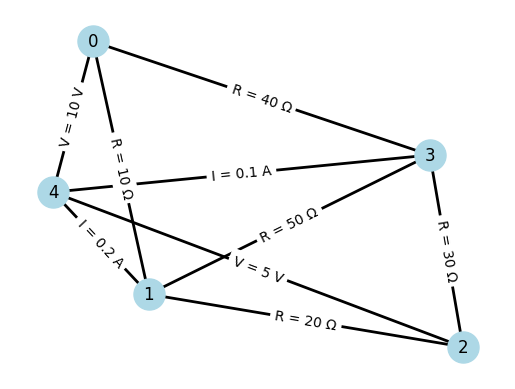

In [70]:
visualize_circuit(circuit)